## Western or Sci-fi? Can deep learning tell a cowboy from an astronaut?

This is an exercise for Lesson 1 of the Fast.ai "Practical Deep Learning for Coders" course, based on the notebook [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) by Jeremy Howard.

We’re going to train a deep neural network to classify the genre of a movie as either Western or Sci-fi, given a movie poster (or any movie picture actually). Initially, I tried using only poster images for the training set, but I figured I would get better results if I used generic movie pictures.

You can test the mode in [Hugging Face Spaces](https://huggingface.co/spaces/heitorfr/western_of_scifi).

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai fastbook duckduckgo_search difPy

## Step 1: Download photos of western and sci-fi movies

Let's start by downloading some movie pictures using DuckDuckGo image search.

In [2]:
import fastbook
from fastbook import *

path = Path('categories')
print(path.resolve())

/kaggle/working/categories


In [3]:
# Clean the dataset if needed
if path.exists():
    shutil.rmtree(path)

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images))

def search_and_download_images(searches, max_images=100, max_size=600):
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} movie photo', max_images))
        resize_images(path/o, max_size=max_size, dest=path/o)

In [5]:
search_and_download_images(['sci-fi', 'western'])

Searching for 'sci-fi movie photo'
Searching for 'western movie photo'


Let’s also download some test images that we’ll use for a later demo. Some of them are quite challenging.

In [6]:
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/terminator.jpg?raw=true', 'test/terminator.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/badland.jpg?raw=true', 'test/badland.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/cowboys_aliens.jpg?raw=true', 'test/cowboys_aliens.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/unforgiven.jpg?raw=true', 'test/unforgiven.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/mad-max.jpg?raw=true', 'test/mad-max.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/interstellar.jpg?raw=true', 'test/interstellar.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/horizon.jpg?raw=true', 'test/horizon.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/astronaut.jpg?raw=true', 'test/astronaut.jpg', show_progress=False)
download_url('https://github.com/heitorfr/fastai-dl-course/blob/ac5bf66af8c112d5e4c2dc53d5428c10602089c3/examples/cowboy.jpg?raw=true', 'test/cowboy.jpg', show_progress=False)

Path('test/cowboy.jpg')

## Step 2: Train our model

First let's cleanup our data. Some photos might not download correctly which could cause our model training to fail, so we'll remove them - `verify_images` checks if the image files can actually be opened:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

16

We can now create the `DataLoaders` object that contains a *training set* and a *validation set*. Check out [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) for an explanation of each of the parameters passed to `DataBlock`.

Let's also peek into the dataset by showing a batch of 32 images.

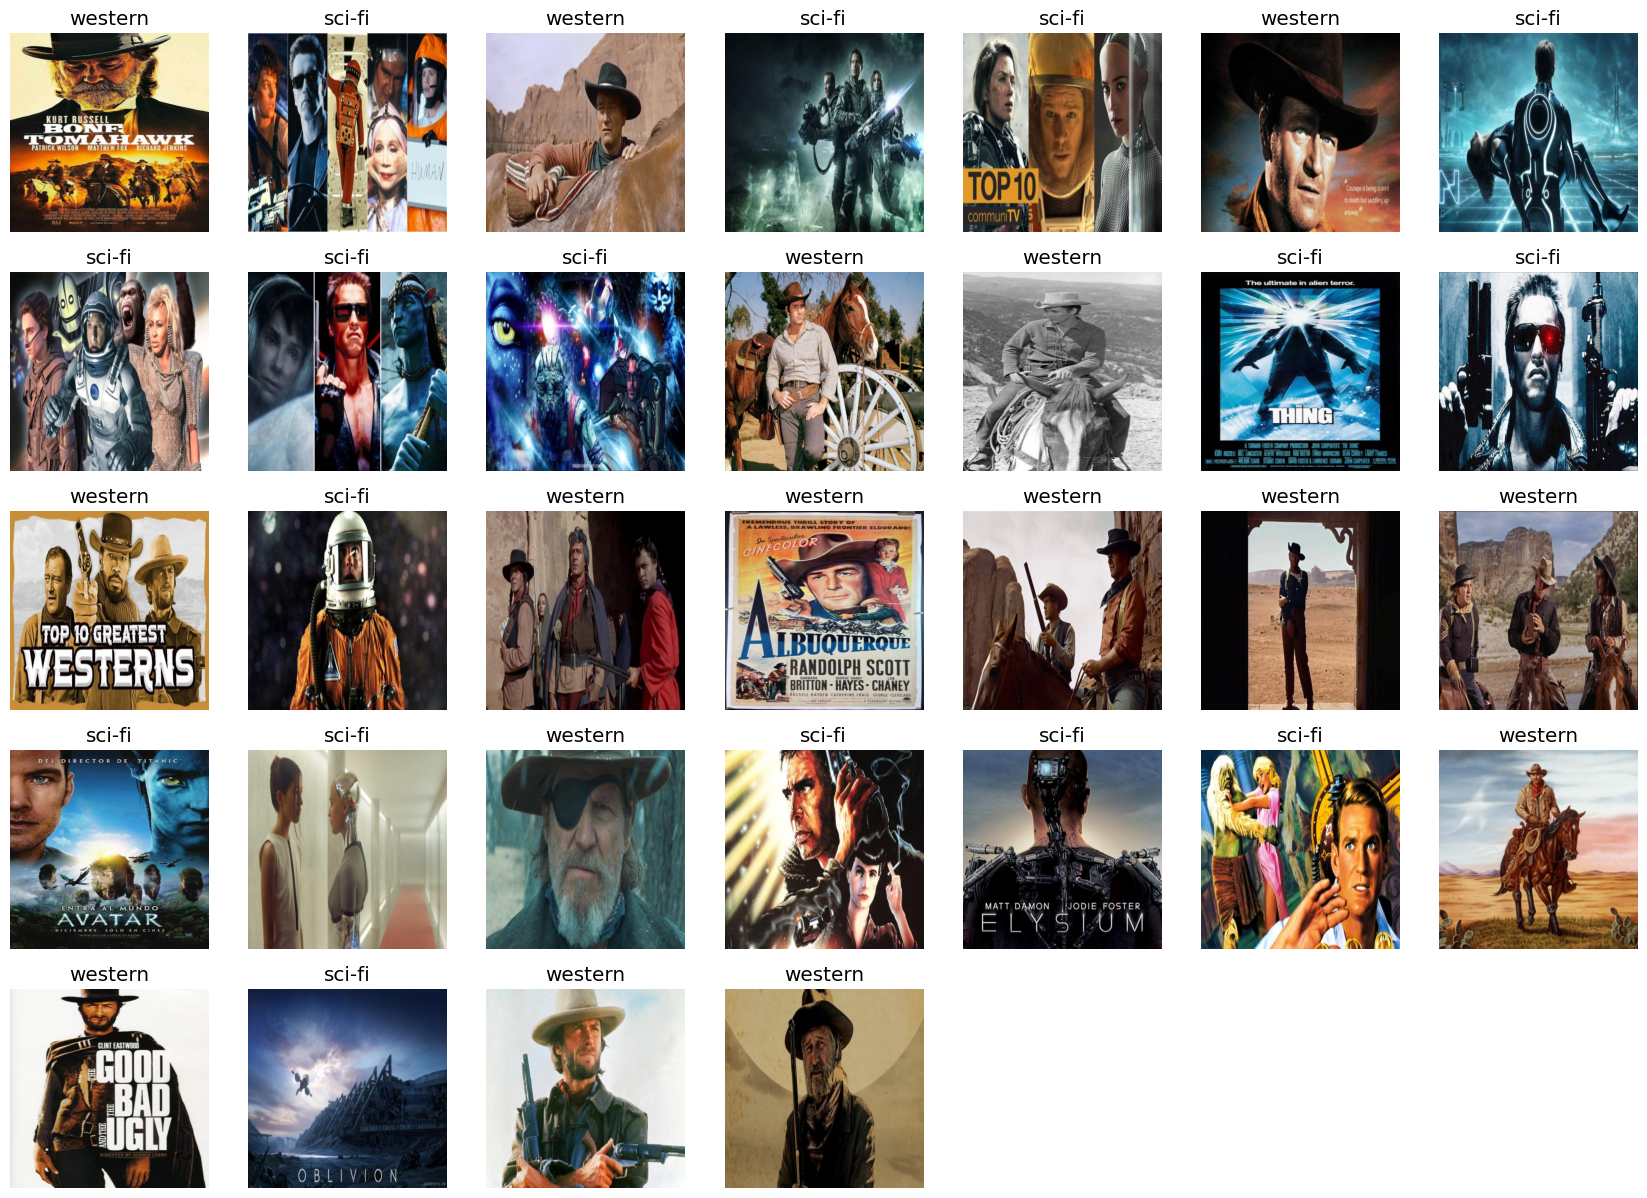

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(600, method='squish')]
).dataloaders(path, bs=32)
dls.show_batch(max_n=32)

And we're now ready to train our model. We'll fine-tune `resnet18`, the fastest widely used computer vision model.

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [9]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


Most of the times you should get accuracy above 0.90.

## Step 3: Use our model
Let's try out our trained model on our hand-picked images.

In [10]:
def predict(image_name):
    category,_,probs = learn.predict(PILImage.create(image_name))
    print(f"This is a {category} movie.")
    print(f"Probability it's a scifi movie: {probs[0]:.4f}") 
    print(f"Probability it's a western movie: {probs[1]:.4f}") 

This is a sci-fi movie.
Probability it's a scifi movie: 0.9995
Probability it's a western movie: 0.0005


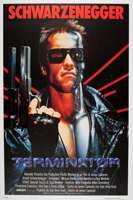

In [11]:
predict('test/terminator.jpg')
Image.open('test/terminator.jpg').to_thumb(200,200)

This is a sci-fi movie.
Probability it's a scifi movie: 0.9972
Probability it's a western movie: 0.0028


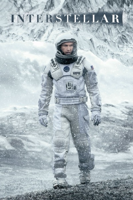

In [12]:
predict('test/interstellar.jpg')
Image.open('test/interstellar.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.0001
Probability it's a western movie: 0.9999


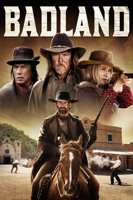

In [13]:
predict('test/badland.jpg')
Image.open('test/badland.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.1934
Probability it's a western movie: 0.8066


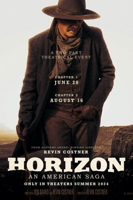

In [14]:
predict('test/horizon.jpg')
Image.open('test/horizon.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.2966
Probability it's a western movie: 0.7034


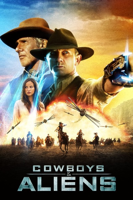

In [15]:
predict('test/cowboys_aliens.jpg')
Image.open('test/cowboys_aliens.jpg').to_thumb(200,200)

Huh? That's a tough one 🤔 I would go 50/50.

This is a sci-fi movie.
Probability it's a scifi movie: 0.7753
Probability it's a western movie: 0.2247


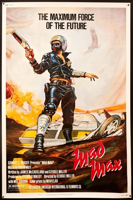

In [16]:
predict('test/mad-max.jpg')
Image.open('test/mad-max.jpg').to_thumb(200,200)

This one is not immediately obvious if you just glance at it.

Now, for fun let's see if the model correclty classifies an image of an astronaut and a cowboy generated by dall-e. The prompt used was:
> Please make two photo-realistic images, one of a cowboy and one of an astronaut. The two pictures should show the subject in the same pose and in the same background. It should be a simple background of dirt ground and a clear blue sky.

This is a western movie.
Probability it's a scifi movie: 0.4613
Probability it's a western movie: 0.5387


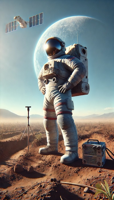

In [17]:
predict('test/astronaut.jpg')
Image.open('test/astronaut.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.0140
Probability it's a western movie: 0.9860


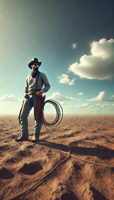

In [18]:
predict('test/cowboy.jpg')
Image.open('test/cowboy.jpg').to_thumb(200,200)

The confidence for the cowboy is usually not great, but still ok. 

I think overall the results are pretty good! Let's check the confusion matrix and top losses.

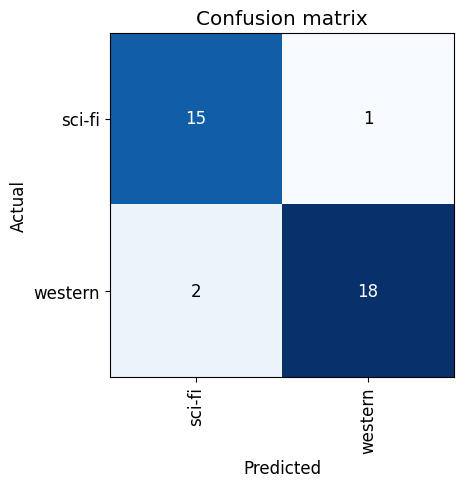

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

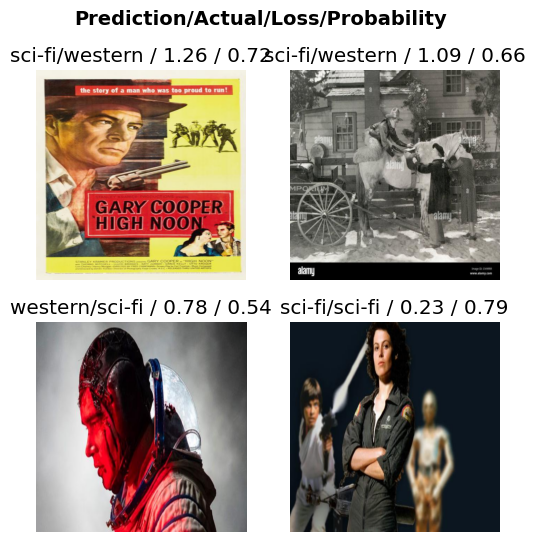

In [20]:
interp.plot_top_losses(4, nrows=2)